# Modelo UNET
## Configuración de ambiente

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *


def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []
    num_filters = [32, 64, 128, 256]
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)
    return x, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    outputs = Concatenate()([outputs1, outputs1])

    model = Model(inputs, outputs)
    return model



## Métricas para el modelo

In [3]:
import os
import numpy as np
import cv2
import json
from glob import glob
from sklearn.utils import shuffle
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model
# from model import build_model, Upsample, ASPP

def create_dir(path):
    """ Create a directory. """
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

def read_data(x, y):
    """ Read the image and mask from the given path. """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask

def read_params():
    """ Reading the parameters from the JSON file."""
    with open("params.json", "r") as f:
        data = f.read()
        params = json.loads(data)
        return params

def load_data(path):
    """ Loading the data from the given path. """
    images_path = os.path.join(path, "image/*")
    masks_path  = os.path.join(path, "mask/*")

    images = glob(images_path)
    masks  = glob(masks_path)

    return images, masks

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_model_weight(path):
    with CustomObjectScope({
        'dice_loss': dice_loss,
        'dice_coef': dice_coef,
        'bce_dice_loss': bce_dice_loss,
        'focal_loss': focal_loss,
        'iou': iou
        }):
        model = load_model(path)
    return model

In [4]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

## Funciones de lectura de archivos y mascaras

In [6]:
import random as r
import skimage.io as io
import cv2
from glob import glob

def seg_rangos(path, end, size_wh=128):
    files = glob(path+end, recursive=True)
    xmin=3000
    xmax=0
    r.seed(42)
    r.shuffle(files)
    for file in files:
        img = io.imread(file, plugin="simpleitk")
        img.astype("float32")
#         print(img.shape)
        for slice in range(img.shape[0]):
            
            img_s = img[slice,:,:]
            img_s = cv2.resize(img_s, (size_wh,size_wh))
            if (np.sum(img_s) > 0):
                xmax = slice if slice >= xmax else xmax 
                xmin = slice if slice <= xmin else xmin             
    return xmin, xmax

def seg_to_array(path, end, rangoMin = 0, rangoMax = 200, size_wh=128):
    files = glob(path+end, recursive=True)
    img_list = []
    r.seed(42)
    r.shuffle(files)    
    for file in files:
#         print(rutaFile)
        img = io.imread(file , plugin="simpleitk")
        img[img != 0] = 1
        img.astype("float32")
        
        for slice in range(rangoMin,rangoMax):
            img_s = img[slice,:,:]
            img_s = cv2.resize(img_s, (size_wh,size_wh))
            
#             img_s = img_s/255.0
#             img_s = img_s.astype(np.float32)
            img_s = np.expand_dims(img_s, axis=0)    
            img_s = np.concatenate([img_s, img_s])
            img_list.append(img_s)            
    return np.array(img_list,np.float32)

def to_array(path, end, rangoMin = 0, rangoMax = 200, size_wh = 128):
    files = glob(path+end, recursive=True)
    img_list = []    
    r.seed(42)
    r.shuffle(files)    
    for file in files:
        img = io.imread(file)
#         img = (img-img.mean())/img.std()
        for slice in range(rangoMin,rangoMax):
            img_s = img[slice,:,:]
            
            img_s = cv2.resize(img_s, (size_wh,size_wh))
            
#             img_s = np.clip(img_s - np.median(img_s)+127, 0, 255)
#             img_s = img_s/255.0
#             img_s = img_s.astype(np.float32)
            img_s = np.expand_dims(img_s, axis=0)
            img_s = np.concatenate([img_s, img_s, img_s])
            
            img_list.append(img_s)
    return np.array(img_list,np.float32)

def vcrep_kpart(X, y, k=5):
    n = X.shape[0]
    t_pliegue = int(n / k)
    perm = np.random.permutation(n)
    X = X[perm]
    y = y[perm]
    masc_val = np.zeros(n, dtype=bool)
    masc_val[0:t_pliegue] = True
    masc_ent = np.logical_not(masc_val)
    X_ent = X[masc_ent]
    y_ent = y[masc_ent]
    X_val = X[masc_val]
    y_val = y[masc_val]
    return X_ent, y_ent, X_val, y_val

def grafico_hist(history):
    fig = plt.gcf()
    fig.set_size_inches(12, 9)

    plt.subplot(2,3,1)
    plt.title('Loss')
    plt.xlabel("epoch")
    plt.plot(history['loss'], color='red', label='train')
    plt.plot(history['val_loss'],color ='blue',label='validation')
    plt.legend(['train', 'val'], loc='upper right')

    plt.subplot(2,3,2)
    plt.title('mIOU')
    plt.xlabel("epoch")
    plt.plot(history['iou'], color='red', label='train')
    plt.plot(history['val_iou'], color='blue', label='validation')
    plt.legend(['train', 'val'], loc='lower right')
    
    plt.subplot(2,3,3)
    plt.title('Precision')
    plt.xlabel("epoch")
    plt.plot(history['precision'], color='red', label='train')
    plt.plot(history['val_precision'], color='blue', label='validation')
    plt.legend(['train', 'val'], loc='lower right')
    
    plt.show()
    
    return

## Lectura y preparación de archivos junto con sus máscaras

In [6]:
np.random.seed(42)
tf.random.set_seed(42)
create_dir("files")

train_path = "/kaggle/input/brats2021-sub-data/BraTS2021_Training_Data_Sub/"
# valid_path = "/kaggle/input/d/daliaydom/cvcclinicdb/new_data/valid"
size_img = 128
ruta = train_path
(xMin, xMax) = seg_rangos(path=ruta, end="**/**seg.nii", size_wh=128)
print(xMin, xMax)
# xMin=80
# xMax=140
train_x = to_array(path=ruta, end="**/**flair.nii", rangoMin = xMin, rangoMax = xMax, size_wh=size_img)
train_y = seg_to_array(path=ruta, end="**/**seg.nii", rangoMin = xMin, rangoMax = xMax, size_wh=size_img)
print(train_x.shape)



0 143
(17875, 3, 128, 128)


## Acotamos el número de imágenes para que el modelo se pueda ejecutar

In [7]:
train_x=train_x[:7000]
train_y=train_y[:7000]


## Generamos un apermutación aleatoria de los índices del conjunto de datos 
Generamos los subconjuntos con 80% entrenamiento y  20% validación

In [8]:
try:
    X_ent, y_ent, X_val, y_val = vcrep_kpart(train_x, train_y,k=5)
except Exception as e:
    print('WARNING: No es posible ejecutar: {}'.format(e))    

train_x = tf.transpose(X_ent, [0, 3, 2, 1])
train_y = tf.transpose(y_ent, [0, 3, 2, 1])
valid_x = tf.transpose(X_val, [0, 3, 2, 1])
valid_y = tf.transpose(y_val, [0, 3, 2, 1])

print("Datos de Entrenamiento", X_ent.shape, y_ent.shape)
print("Datos de Validación", X_val.shape, y_val.shape)


2022-12-04 06:16:04.325419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 06:16:04.327818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 06:16:04.479204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 06:16:04.480519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 06:16:04.481702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Datos de Entrenamiento (5600, 3, 128, 128) (5600, 2, 128, 128)
Datos de Validación (1400, 3, 128, 128) (1400, 2, 128, 128)


2022-12-04 06:16:10.090692: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 275251200 exceeds 10% of free system memory.


## Configuramos los parámetros e hiperparámetros para la ejecucuón del modelo 

In [9]:
model_path = "files/model.h5"
batch_size = 16
epochs = 100
lr = 1e-5
shape = (128, 128, 3)

model = build_model(shape)
metrics = [
    dice_coef,
    iou,
    Recall(),
    Precision()
]

# train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
# valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

model.compile(loss=binary_crossentropy, optimizer=Adam(lr), metrics=metrics)

callbacks = [
    ModelCheckpoint(model_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20),
    CSVLogger("files/data.csv"),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]

train_steps = (len(train_x)//batch_size)
valid_steps = (len(valid_x)//batch_size)

if len(train_x) % batch_size != 0:
    train_steps += 1

if len(valid_x) % batch_size != 0:
    valid_steps += 1


2022-12-04 06:16:11.335684: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-04 06:16:11.335731: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-04 06:16:11.339121: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-12-04 06:16:11.695131: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-04 06:16:11.695326: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


## Ejecución del modelo

In [10]:
model.fit(
    train_x, 
    train_y,
    epochs=epochs,
    validation_data=(valid_x, valid_y),
    batch_size=batch_size,
    callbacks=callbacks,
    shuffle=False)

2022-12-04 06:16:11.914387: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1101004800 exceeds 10% of free system memory.
2022-12-04 06:16:12.811645: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 734003200 exceeds 10% of free system memory.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-12-04 06:16:13.480231: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-04 06:16:18.731980: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/350 [..............................] - ETA: 1:31:05 - loss: 0.8318 - dice_coef: 0.0091 - iou: 0.0046 - recall: 0.4725 - precision: 0.0031

2022-12-04 06:16:29.307740: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-04 06:16:29.307792: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/350 [..............................] - ETA: 5:15 - loss: 0.8308 - dice_coef: 0.0151 - iou: 0.0076 - recall: 0.3871 - precision: 0.0043   

2022-12-04 06:16:30.116122: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-04 06:16:30.117211: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-04 06:16:30.283680: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 946 callback api events and 940 activity events. 
2022-12-04 06:16:30.311483: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


  3/350 [..............................] - ETA: 3:53 - loss: 0.8198 - dice_coef: 0.0165 - iou: 0.0083 - recall: 0.4122 - precision: 0.0048

2022-12-04 06:16:30.353180: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_12_04_06_16_30

2022-12-04 06:16:30.375752: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_12_04_06_16_30/162c8645f0f5.trace.json.gz
2022-12-04 06:16:30.431517: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_12_04_06_16_30

2022-12-04 06:16:30.439133: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_12_04_06_16_30/162c8645f0f5.memory_profile.json.gz
2022-12-04 06:16:30.441132: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/train/plugins/profile/2022_12_04_06_16_30
Dumped tool data for xplane.pb to logs/train/plugins/profile/2022_12_04_06_16_30/162c8645f0f5.xplane.

350/350 [==============================] - 61s 131ms/step - loss: 0.5683 - dice_coef: 0.0266 - iou: 0.0135 - recall: 0.4943 - precision: 0.0382 - val_loss: 0.5425 - val_dice_coef: 0.0278 - val_iou: 0.0141 - val_recall: 0.4930 - val_precision: 0.1113
Epoch 2/100
350/350 [==============================] - 45s 129ms/step - loss: 0.4319 - dice_coef: 0.0300 - iou: 0.0153 - recall: 0.3366 - precision: 0.3100 - val_loss: 0.4111 - val_dice_coef: 0.0313 - val_iou: 0.0160 - val_recall: 0.3960 - val_precision: 0.4028
Epoch 3/100
350/350 [==============================] - 46s 133ms/step - loss: 0.3920 - dice_coef: 0.0324 - iou: 0.0165 - recall: 0.4078 - precision: 0.5147 - val_loss: 0.3764 - val_dice_coef: 0.0333 - val_iou: 0.0170 - val_recall: 0.4113 - val_precision: 0.6305
Epoch 4/100
350/350 [==============================] - 46s 131ms/step - loss: 0.3660 - dice_coef: 0.0355 - iou: 0.0181 - recall: 0.5308 - precision: 0.6406 - val_loss: 0.3512 - val_dice_coef: 0.0372 - val_iou: 0.0190 - val_rec

In [11]:
import matplotlib.pyplot as plt

# sample = tf.transpose(train_x, [0, 3, 2, 1])
# pred = tf.transpose(pred, [0, 3, 2, 1])

# plt.imshow(sample[250],cmap='inferno');

In [13]:
import shutil
shutil.make_archive('files', 'zip', '/kaggle/working/files')

'/kaggle/working/files.zip'

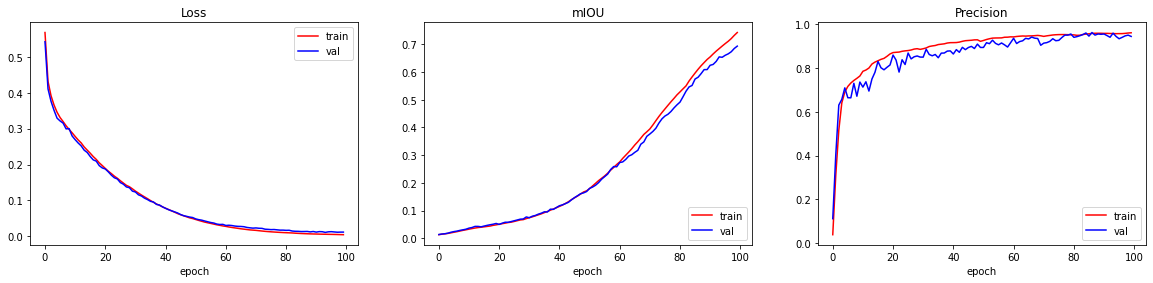

In [12]:
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

PATH_HISTORY = "/kaggle/input/files-unet-cerebro/files/data.csv"
history = pd.read_csv(PATH_HISTORY)
grafico_hist(history)

In [13]:
shape = (128, 128, 3)
model = build_model(shape)

2022-12-05 01:47:48.392470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 01:47:48.393585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 01:47:48.596543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 01:47:48.597440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 01:47:48.598175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [14]:
model_path = "/kaggle/input/files-unet-cerebro/files/model.h5"
model.load_weights(model_path)

In [26]:
train_path = "/kaggle/input/brats2021-sub-data/BraTS2021_Training_Data_Sub/"
muestra = "00343"
rm = "BraTS2021_" + muestra + "/BraTS2021_" + muestra + "_flair.nii"
seg = "BraTS2021_" + muestra + "/BraTS2021_" + muestra + "_seg.nii"
# valid_path = "/kaggle/input/d/daliaydom/cvcclinicdb/new_data/valid"
size_img = 128
ruta = train_path
(xMin, xMax) = seg_rangos(path=ruta, end=seg, size_wh=128)
print(xMin, xMax)
test_x = to_array(path=ruta, end=rm, rangoMin = xMin, rangoMax = xMax, size_wh=size_img)
test_y = seg_to_array(path=ruta, end=seg, rangoMin = xMin, rangoMax = xMax, size_wh=size_img)


42 99


(1, 2, 128, 128)


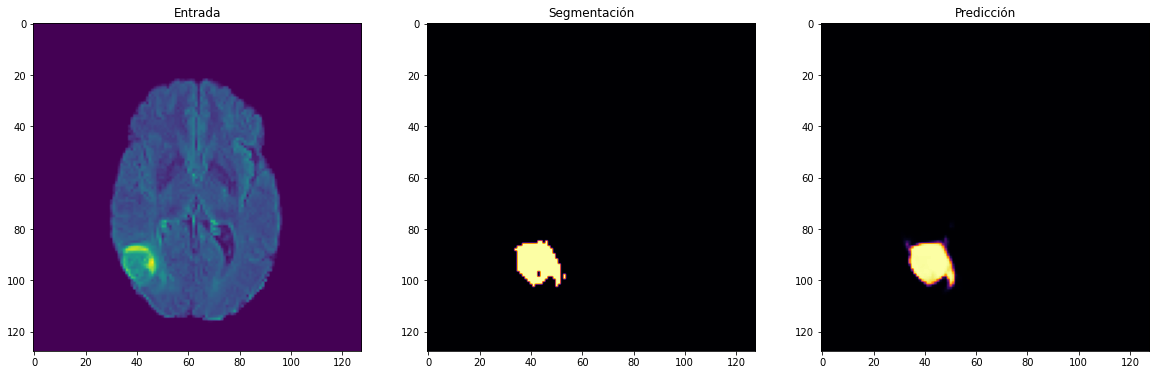

In [28]:
plano=30
X_prueba = test_x
sample = np.expand_dims(X_prueba[plano], axis=0)
sample = tf.transpose(sample, [0, 3, 2, 1])
pred = model.predict(sample)
pred = tf.transpose(pred, [0, 3, 2, 1])

print(pred.shape)

fig = plt.gcf()
fig.set_size_inches(20, 15)
plt.subplot(2,3,1)
plt.title('Entrada')
plt.imshow(X_prueba[plano][0]);

plt.subplot(2,3,2)
plt.title('Segmentación')
plt.imshow(test_y[plano][0],cmap="inferno");

plt.subplot(2,3,3)
plt.title('Predicción')
plt.imshow(pred[0][0],cmap="inferno");

plt.show()